In [1]:
! pip install langgraph langsmith langchain-openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 885.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.2/292.2 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.9/399.9 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.0/383.0 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.0/378.0 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from typing import TypedDict, Annotated
from langchain_openai import ChatOpenAI
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

In [2]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "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"
# LangSmith 项目名称，默认 default
os.environ["LANGCHAIN_PROJECT"] = "default"

In [4]:
llm = ChatOpenAI(
    model="gpt-4o",
    api_key="sk-T6SlqfUnyFytejvA3c1584F87d6343878232185e26243b1d",
    base_url="https://api.apiyi.com/v1"
)

In [5]:
class State(TypedDict):
  messages: Annotated[list, add_messages]

In [6]:
source_lang = "Chinese"
target_lang = "English"

In [8]:
## 初始翻译
def initial_translation(state: State):
  source_text = state["messages"][-1].content
  system_prompt = f"You are an expert linguist, specializing in translation from {source_lang} to {target_lang}."
  translation_prompt = f"""This is an {source_lang} to {target_lang} translation, please provide the {target_lang} translation for this text. \
  Do not provide any explanations or text apart from the translation.
  {source_lang}: {source_text}

  {target_lang}:"""

  messages = [
     (
      "system",
      system_prompt,
     ),
      ("human", translation_prompt),
  ]
  return {"messages": [llm.invoke(messages)]}

## 对结果进行反思
def reflect_on_translation(state: State):
    country = "America"
    # 获取输入的原文（User 消息）
    source_text = state["messages"][-2].content
    # 获取翻译（Assistant 消息）
    translation_1 = state["messages"][-1].content
    system_message = f"You are an expert linguist specializing in translation from {source_lang} to {target_lang}. \
You will be provided with a source text and its translation and your goal is to improve the translation."

    reflection_prompt = f"""Your task is to carefully read a source text and a translation from {source_lang} to {target_lang}, and then give constructive criticism and helpful suggestions to improve the translation. \
    The final style and tone of the translation should match the style of {target_lang} colloquially spoken in {country}.

    The source text and initial translation, delimited by XML tags <SOURCE_TEXT></SOURCE_TEXT> and <TRANSLATION></TRANSLATION>, are as follows:

    <SOURCE_TEXT>
    {source_text}
    </SOURCE_TEXT>

    <TRANSLATION>
    {translation_1}
    </TRANSLATION>

    When writing suggestions, pay attention to whether there are ways to improve the translation's \n\
    (i) accuracy (by correcting errors of addition, mistranslation, omission, or untranslated text),\n\
    (ii) fluency (by applying {target_lang} grammar, spelling and punctuation rules, and ensuring there are no unnecessary repetitions),\n\
    (iii) style (by ensuring the translations reflect the style of the source text and take into account any cultural context),\n\
    (iv) terminology (by ensuring terminology use is consistent and reflects the source text domain; and by only ensuring you use equivalent idioms {target_lang}).\n\

    Write a list of specific, helpful and constructive suggestions for improving the translation.
    Each suggestion should address one specific part of the translation.
    Output only the suggestions and nothing else."""

    messages = [
        ("system",system_message,),
        ("human", reflection_prompt),
    ]
    return {"messages": [llm.invoke(messages)]}

## 优化翻译
def improve_translation(state: State):
    # 输入原文（User 消息）
    source_text = state["messages"][-3].content
    # 初始翻译结果（Assistant 消息）
    translation_1 = state["messages"][-2].content
    # 反思建议（Assistant 消息）
    reflection = state["messages"][-1].content

    system_message = f"You are an expert linguist, specializing in translation editing from {source_lang} to {target_lang}."

    improve_prompt = f"""Your task is to carefully read, then edit, a translation from {source_lang} to {target_lang}, taking into
    account a list of expert suggestions and constructive criticisms.

    The source text, the initial translation, and the expert linguist suggestions are delimited by XML tags <SOURCE_TEXT></SOURCE_TEXT>, <TRANSLATION></TRANSLATION> and <EXPERT_SUGGESTIONS></EXPERT_SUGGESTIONS> \
    as follows:

    <SOURCE_TEXT>
    {source_text}
    </SOURCE_TEXT>

    <TRANSLATION>
    {translation_1}
    </TRANSLATION>

    <EXPERT_SUGGESTIONS>
    {reflection}
    </EXPERT_SUGGESTIONS>

    Please take into account the expert suggestions when editing the translation. Edit the translation by ensuring:

    (i) accuracy (by correcting errors of addition, mistranslation, omission, or untranslated text),
    (ii) fluency (by applying {target_lang} grammar, spelling and punctuation rules and ensuring there are no unnecessary repetitions), \
    (iii) style (by ensuring the translations reflect the style of the source text)
    (iv) terminology (inappropriate for context, inconsistent use), or
    (v) other errors.

    Output only the new translation and nothing else."""

    messages = [
        (
            "system",
            system_message,
        ),
        ("human", improve_prompt),
    ]
    return {"messages": [llm.invoke(messages)]}

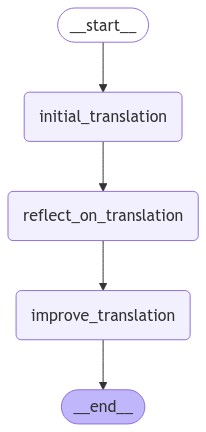

In [10]:
w = StateGraph(State)
w.add_node("initial_translation", initial_translation)
w.add_node("reflect_on_translation", reflect_on_translation)
w.add_node("improve_translation", improve_translation)

w.set_entry_point("initial_translation")
w.add_edge("initial_translation", "reflect_on_translation")
w.add_edge("reflect_on_translation", "improve_translation")
w.set_finish_point("improve_translation")

g = w.compile()
display(Image(g.get_graph().draw_mermaid_png()))

In [11]:
"""
静夜思\n
床前明月光，疑是地上霜。\n
举头望明月，低头思故乡。\n
"""
user_input = input("输入中翻英内容: ")
events = g.stream(
    {"messages": [("user", user_input)]}, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

输入中翻英内容: 静夜思\n 床前明月光，疑是地上霜。\n 举头望明月，低头思故乡。\n
================================ Human Message =================================

静夜思\n 床前明月光，疑是地上霜。\n 举头望明月，低头思故乡。\n
================================== Ai Message ==================================

Quiet Night Thoughts

Before my bed, the bright moonlight glows,  
I suspect it is frost on the ground.  
I raise my head to gaze at the bright moon,  
Then lower it to think of my hometown.
================================== Ai Message ==================================

1. **Title Accuracy and Style**: Consider changing the title to "Thoughts on a Quiet Night" to better reflect the original tone and meaning.

2. **Line 1 Fluency**: "Before my bed, the bright moonlight glows," could be streamlined for natural flow. Try "Moonlight shines bright before my bed."

3. **Line 2 Accuracy and Style**: "I suspect it is frost on the ground." could be rephrased for poetic tone and clarity. Consider "Is it frost on the ground, I wonder?"

4. **Line 3 Fluen